## Spatial Autocorrelation and Regression of Airbnb in Bandung and Jakarta, Indonesia

In [1]:
#Upload necessary libraries
import sys
import os
sys.path.append(os.path.abspath('..'))
import geopandas as gpd
import seaborn as sns
import libpysal as lps
from libpysal.weights import Queen, Rook, KNN
import pysal as ps
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import pysal.viz as viz
import urllib
import zipfile
from splot.esda import lisa_cluster

from spreg import OLS
from spreg import ML_Error
from spreg import ML_Lag

# ignore warnings message presence
import warnings
warnings.simplefilter('ignore')

### Data Exploration
Let's have a look at our dataset

In [2]:
# Data Sources

# Read the Cleaned Airbnb and POI dataset (aggregated into Kelurahan)
airbnb_bdg = gpd.read_file(os.path.join('AirbnbPOI_bdg.shp'))
airbnb_bdg = airbnb_bdg.fillna(0)
airbnb_bdg.columns

Index(['OBJECTID', 'swk', 'kode_kecam', 'nama_kecam', 'nama_kelur',
       'shape_leng', 'shape_area', 'listings_c', 'Mean Price', 'OBJECTID_x',
       'kode_kec_1', 'shape_le_1', 'shape_ar_1', 'Zipcode', 'Neighborho',
       'Metropolit', 'ADR_USD', 'Average _1', 'Revenue_US', 'Revenue_ID',
       'Occupancy', 'Bookings', 'Number o_1', 'Bedrooms', 'Bathrooms',
       'Max Guests', 'Response R', 'Security D', 'Security_1', 'Cleaning F',
       'Cleaning_1', 'Extra Peop', 'Extra Pe_1', 'Published', 'Publishe_1',
       'Publishe_2', 'Minimum St', 'Count Rese', 'Count Avai', 'Count Bloc',
       'Number o_2', 'Instantboo', 'Latitude', 'Longitude', 'Overall Ra',
       'Airbnb Com', 'Airbnb Acc', 'Airbnb Cle', 'Airbnb Che', 'Airbnb Loc',
       'Airbnb Val', 'Airbnb Pro', 'Airbnb Hom', 'License', 'Airbnb P_1',
       'Airbnb Hos', 'index_righ', 'OBJECTID_y', 'kode_kec_2', 'shape_le_2',
       'shape_ar_2', 'PPB', 'mall', 'restaurant', 'attraction', 'parks',
       'hotels', 'Hotel_Dens', 

In [3]:
airbnb_jkt = gpd.read_file(os.path.join('AirbnbPOI_jkt.shp'))
airbnb_jkt = airbnb_jkt.fillna(0)
airbnb_jkt.columns

Index(['KEL_NAME', 'Kecamatan', 'ID', 'listings_c', 'Zipcode', 'Neighborho',
       'Metropolit', 'ADR_USD', 'ADR_IDR', 'Revenue_US', 'Revenue_ID',
       'Occupancy', 'Bookings', 'Number o_1', 'Bedrooms', 'Bathrooms',
       'Max Guests', 'Response R', 'Security D', 'Security_1', 'Cleaning F',
       'Cleaning_1', 'Extra Peop', 'Extra Pe_1', 'Published', 'Publishe_1',
       'Publishe_2', 'Minimum St', 'Count Rese', 'Count Avai', 'Count Bloc',
       'Number o_2', 'Instantboo', 'Latitude', 'Longitude', 'Overall Ra',
       'Airbnb Com', 'Airbnb Acc', 'Airbnb Cle', 'Airbnb Che', 'Airbnb Loc',
       'Airbnb Val', 'Airbnb Pro', 'Airbnb Hom', 'License', 'Airbnb P_1',
       'Airbnb Hos', 'index_righ', 'parks', 'malls', 'attraction',
       'restaurant', 'hotels', 'Hotel_Dens', 'Mall_Densi', 'Restaura_1',
       'Attracti_1', 'Parks_Dens', 'geometry'],
      dtype='object')

### Spatial Weight

Spatial weights are mathematical structures representing for spatial relationships, and are crucial components of spatial analysis. Generally it is a $nxn$ matrix measuring the potential spatial relationships between paired observations in a spatial dataset，which is on $n$ locations with varied geometries. The spatial relationships between these geometries can be based on criteria like:
- Contiguity Based Weights
- Distance Based Weights (both geospatial distance and general distance)
- Kernel Weights

In spatial weights matrix, the geographical space is encoded into numerical form for statistical practice.The elements in diagons $w_{ii}$ are set to zero while the rest cells $w_{ij}$ measure the potential interactions between each pair at location $i$ and $j$.

We are going to realize the function using `PySAL` to create, manipulate and analyze spatial weights matrices across different types in the following section. For further details see the Spatial Weights [API](https://pysal.readthedocs.io/en/latest/api.html).

Contiguity Weights can be built from dataframe with a geometry column or from  contiguity graph representation, e.g.shapefile. In this section, we will use contiguity to define neighboring observations: use `weights.Contiguity`module in `PySAL` to constructe and manipulate spatial weights matrices based on contiguity criteria; and to use `weights.Contiguity` in `libpysal` to further get the idea plotted out.

Three contiguity weights will be compared: **Queen**, **Rook** and **Bishop**. In this paper, we will use Queen contiguity weight.

#### Queen contiguity weight
This commonly used weight type build a queen contiguity matrix for our data, , reflecting the adjacency relationship whether a polygon shares an **edge** or a **vertex** with another polygon or not. A pair of boroughs to be considered neighbours under this $W$ will need to "touch" each other to some degree. As the weights are symmetric, if borough $A$ neighbors borough $B$, then both $w_{AB} = 1$ and $w_{BA} = 1$.

We will begin with the `GeoDataFrame` and pass it on to the queen contiguity weights builder in `PySAL` (`ps.lib.weights.Queen.from_dataframe`). 

In [121]:
# Create the spatial weights matrix
w_queen = Queen.from_dataframe(airbnb_bdg)
w_queen_jkt = Queen.from_dataframe(airbnb_jkt)
w_queen_jkt.n

524

In [122]:
print ('%.4f'%w_queen.pct_nonzero) # percentage of non zero queen weights

3.9011


In [123]:
w_queen.histogram # frequency of n neighbors 

[(3, 2),
 (4, 0),
 (5, 6),
 (6, 0),
 (7, 36),
 (8, 0),
 (9, 56),
 (10, 0),
 (11, 64),
 (12, 0),
 (13, 56),
 (14, 0),
 (15, 48),
 (16, 0),
 (17, 20),
 (18, 0),
 (19, 10),
 (20, 0),
 (21, 4)]

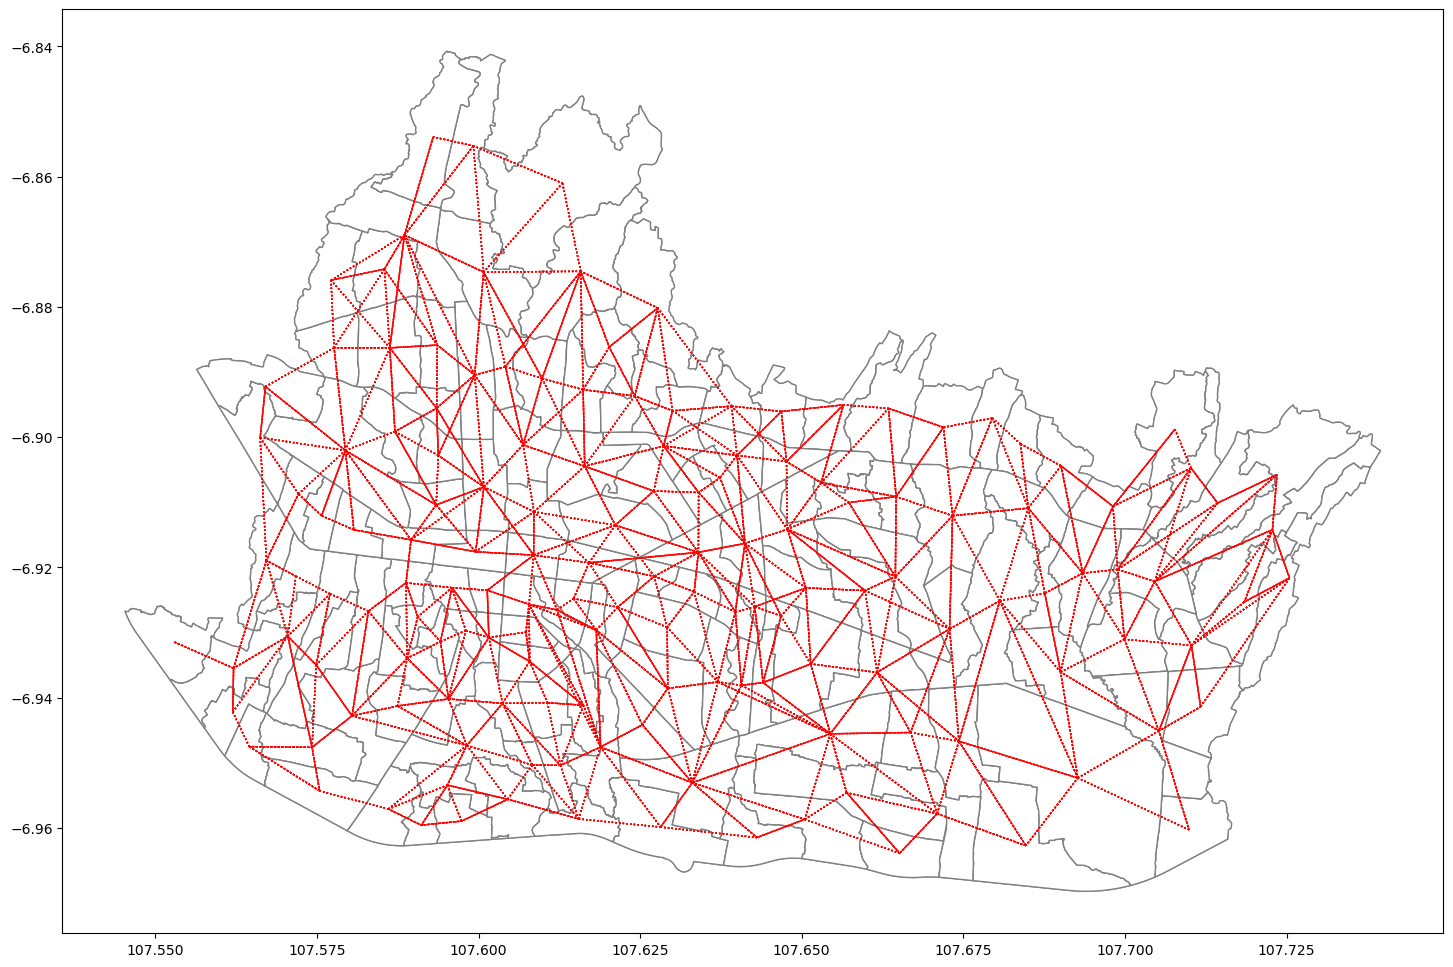

In [124]:
# Let's plot the contiguity neighbour
ax = airbnb_bdg.plot(edgecolor='grey', facecolor='w', figsize=(20, 12))
f,ax = w_queen.plot(airbnb_bdg, ax=ax, 
                   edge_kws=dict(color='r', linestyle=':', linewidth=1),
                   node_kws=dict(marker=''))

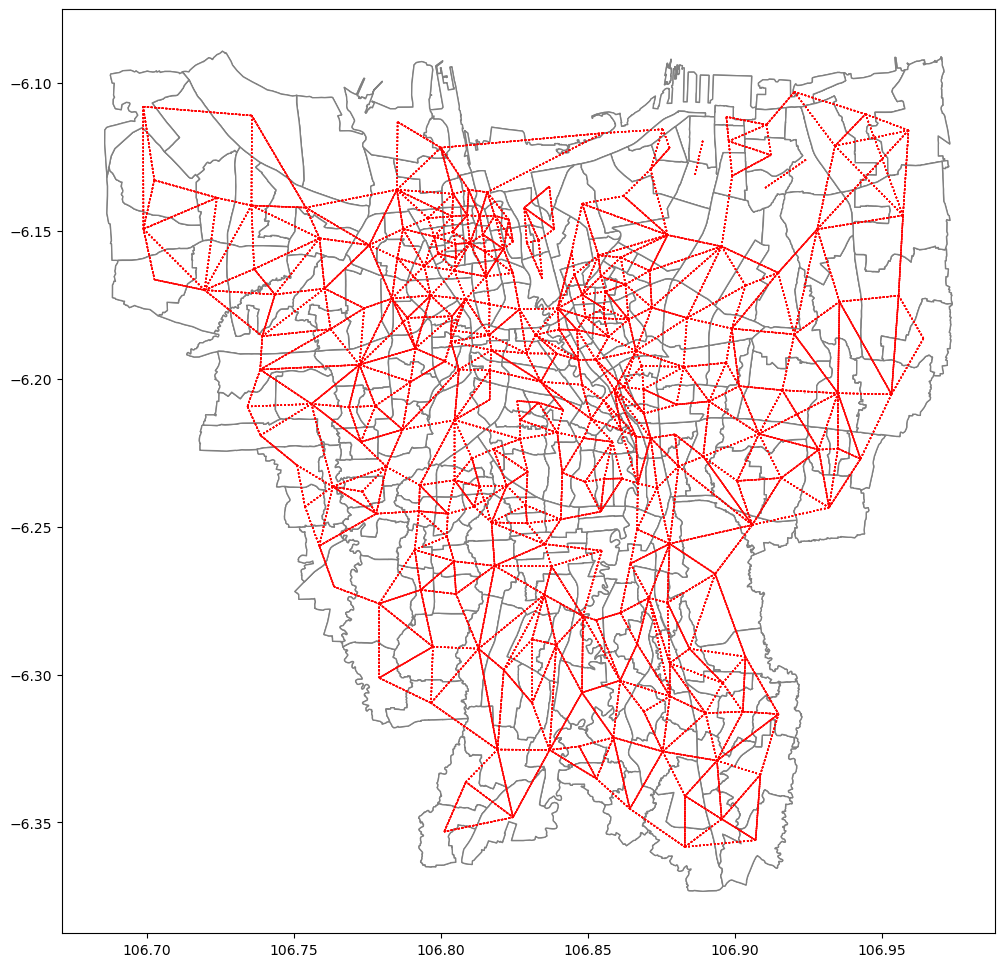

In [125]:
# Let's plot the contiguity neighbour
ax = airbnb_jkt.plot(edgecolor='grey', facecolor='w', figsize=(20, 12))
f,ax = w_queen_jkt.plot(airbnb_jkt, ax=ax, 
                   edge_kws=dict(color='r', linestyle=':', linewidth=1),
                   node_kws=dict(marker=''))

### Spatial Autocorrelation
Spatial autocorrelation could be defined as "absence of spatial randomness" in that, for a given dataset, the  𝑠𝑖𝑚𝑖𝑙𝑎𝑟𝑖𝑡𝑦   𝑖𝑛   𝑣𝑎𝑙𝑢𝑒𝑠  among observations relates to their  𝑙𝑜𝑐𝑎𝑡𝑖𝑜𝑛𝑎𝑙   𝑠𝑖𝑚𝑖𝑙𝑎𝑟𝑖𝑡𝑦 ; hence relates the target observation's value with values in neighboring locations for specific variable. So in the following, we are trying to generate the meansures for spatial similarity and attribute similarity respectively, which had been utilized widely to generate combined measures for spatial autocorrelation.

In [126]:
W_queen = Queen.from_shapefile('AirbnbPOI_bdg.shp')
W_queen.transform = 'r' # row-standardize the contiguity weights
W_queen.n

302

In [127]:
airbnb_bdg['listings_c']

0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
      ... 
297    0.0
298    3.0
299    0.0
300    1.0
301    0.0
Name: listings_c, Length: 302, dtype: float64

In [128]:
airbnb_Lag = lps.weights.lag_spatial(W_queen, airbnb_bdg['listings_c']) #spatial lag of the variable
airbnb_LagQ5 = ps.viz.mapclassify.Quantiles(airbnb_Lag, k=5) # let's say k=5 for example

In [129]:
# Now do the same with Jakarta dataset
W_queen_jkt = Queen.from_shapefile('airbnb_jkt_regions.shp')
W_queen_jkt.transform = 'r' # row-standardize the contiguity weights
airbnb_Lag_jkt = lps.weights.lag_spatial(W_queen_jkt, airbnb_jkt['listings_c']) #spatial lag of the variable
airbnb_LagQ5_jkt = ps.viz.mapclassify.Quantiles(airbnb_Lag_jkt, k=5) # let's say k=5 for example

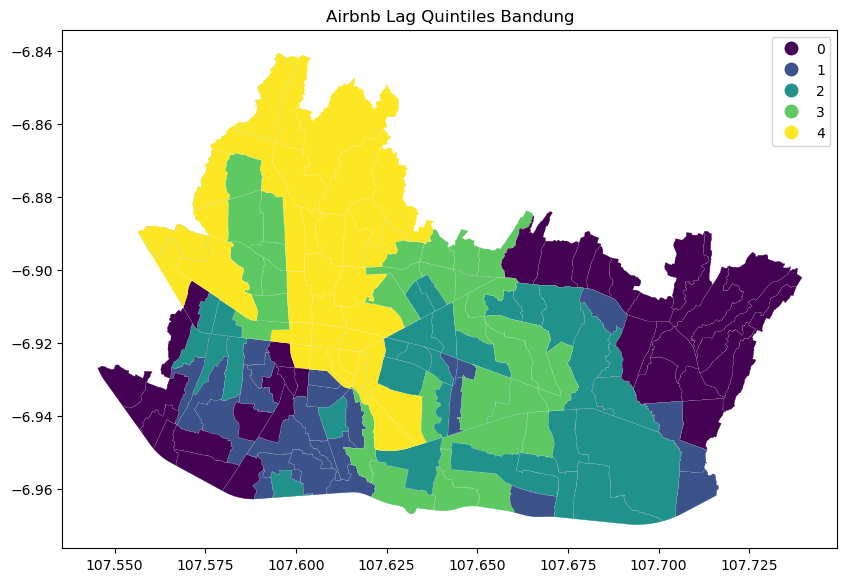

In [130]:
f, ax = plt.subplots(1, figsize=(10, 8))
airbnb_bdg.assign(cl_lag=airbnb_LagQ5.yb).plot(column='cl_lag', categorical=True, k=5, cmap='viridis', linewidth=0.1, ax=ax, edgecolor='white', legend=True)
plt.title('Airbnb Lag Quintiles Bandung')
plt.show()

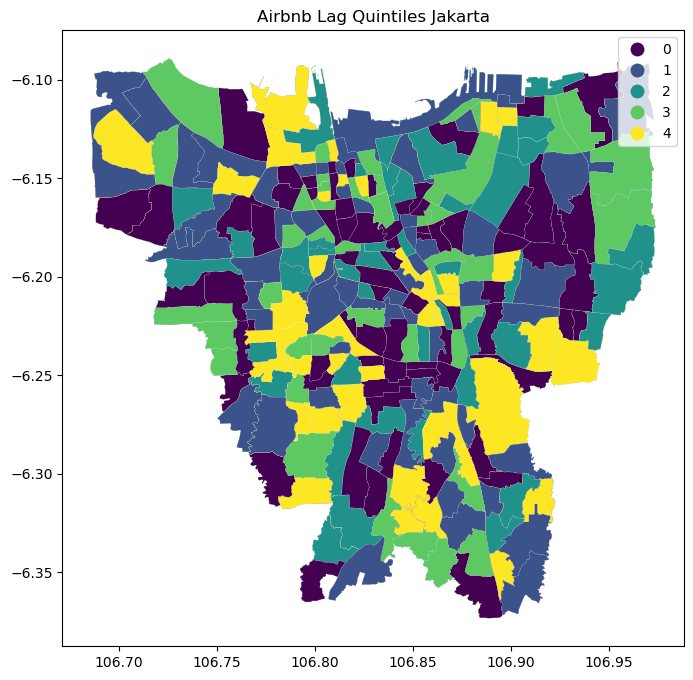

In [131]:
f, ax = plt.subplots(1, figsize=(10, 8))
airbnb_jkt.assign(cl_lag=airbnb_LagQ5_jkt.yb).plot(column='cl_lag', categorical=True, k=5, cmap='viridis', linewidth=0.1, ax=ax, edgecolor='white', legend=True)
plt.title('Airbnb Lag Quintiles Jakarta')
plt.show()

### Moran Plot
Moran scatter plot is similar to normal scatter plot, but widely used to visualize spatial autocorrelation, with the variable of interest against x axis, whilst its spatial lag against y axis.

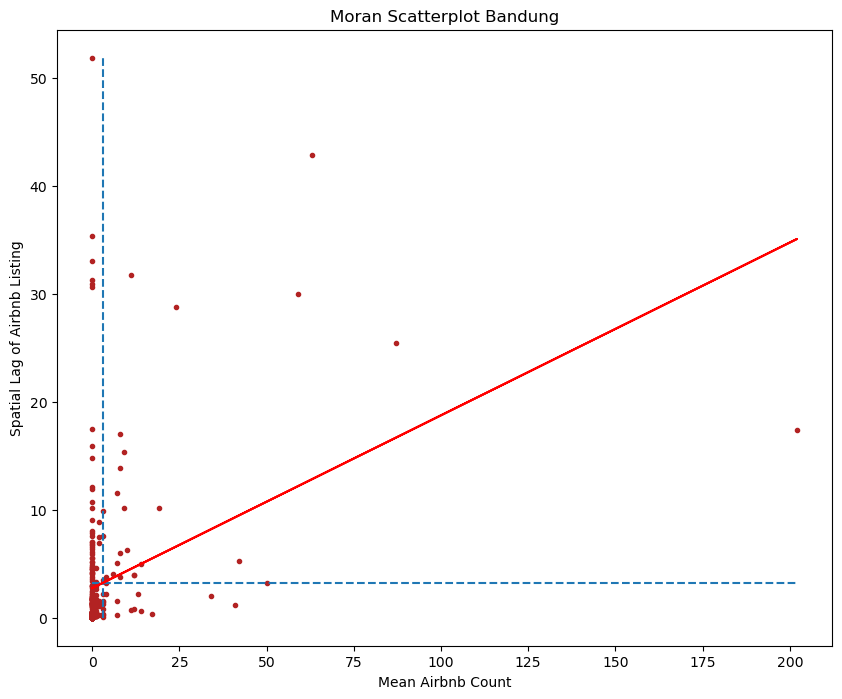

In [132]:
airbnb=airbnb_bdg['listings_c']
b,a = np.polyfit(airbnb, airbnb_Lag, 1)
f, ax = plt.subplots(1, figsize=(10, 8))
plt.plot(airbnb, airbnb_Lag, '.', color='firebrick')

 # dashed vert at mean of the last year's private rent level
plt.vlines(airbnb.mean(), airbnb_Lag.min(), airbnb_Lag.max(), linestyle='--')
 # dashed horizontal at mean of lagged private rent
plt.hlines(airbnb_Lag.mean(), airbnb.min(), airbnb.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(airbnb, a + b*airbnb, 'r')
plt.title('Moran Scatterplot Bandung')
plt.ylabel('Spatial Lag of Airbnb Listing')
plt.xlabel('Mean Airbnb Count')
plt.show()

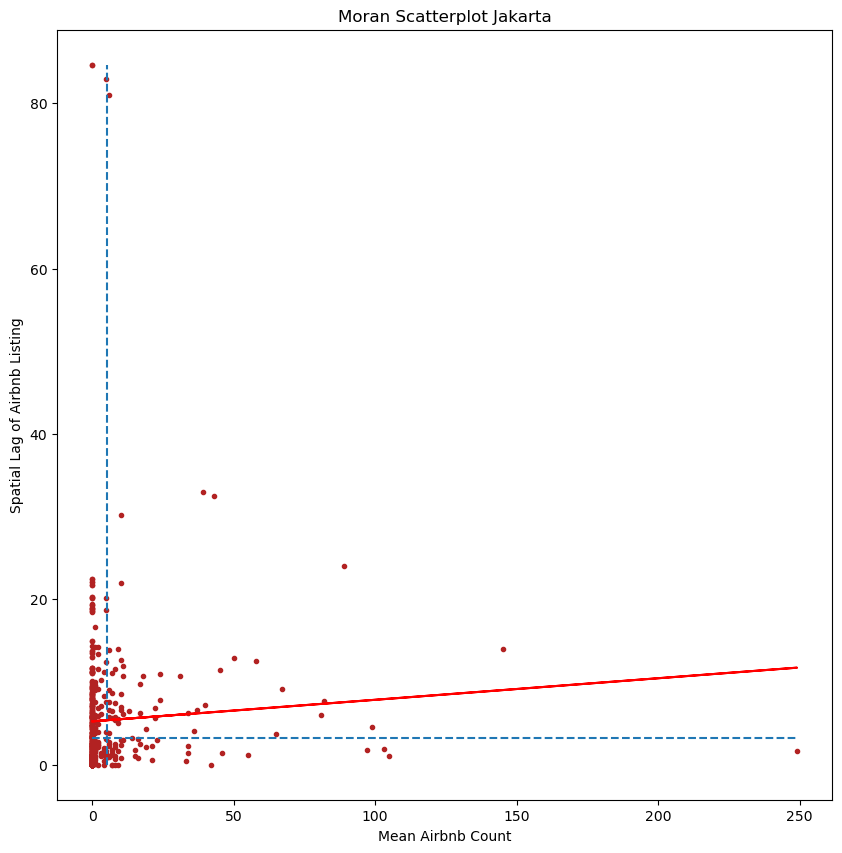

In [133]:
airbnb2=airbnb_jkt['listings_c']
b,a = np.polyfit(airbnb2, airbnb_Lag_jkt, 1)
f, ax = plt.subplots(1, figsize=(10, 10))
plt.plot(airbnb2, airbnb_Lag_jkt, '.', color='firebrick')

 # dashed vert at mean of the last year's private rent level
plt.vlines(airbnb2.mean(), airbnb_Lag_jkt.min(), airbnb_Lag_jkt.max(), linestyle='--')
 # dashed horizontal at mean of lagged private rent
plt.hlines(airbnb_Lag.mean(), airbnb2.min(), airbnb2.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(airbnb2, a + b*airbnb2, 'r')
plt.title('Moran Scatterplot Jakarta')
plt.ylabel('Spatial Lag of Airbnb Listing')
plt.xlabel('Mean Airbnb Count')
plt.show()

Be obvious from the plot that, these two variables have positive relationship, which leads to next section about two main types of spatial autocorrelations (SA): 
- **Positive spatial autocorrelation**: similar values tend to group together in similar locations. Generally, high values tend to be surrounded by high values, and low values to be close to low values, with justification of main pattern as clustered.
- **Negative spatial autocorrelation**: similar values tend to be dispersed and further apart from each other. Generally, high values tend to be surrounded by low values, and low values to be close to high values, with justification of main pattern as sparsed.

Meanwhile, we normally have two main classes of SA: (1) **Global spatial autocorrelation** and (2) **Local spatial autocorrelation**; and use Exploratory Spatial Data Analysis (`ESDA`) tools to realize the analysis purpose, i.e. spatial queries, statistical inference, choropleths, etc. 

In [134]:
from pysal.explore import esda 
mi = esda.moran.Moran(airbnb_bdg['listings_c'], w_queen) # call moran function
mi.I # print out the moran's I value

0.15999456721761104

Text(0.5, 0, "Moran's I")

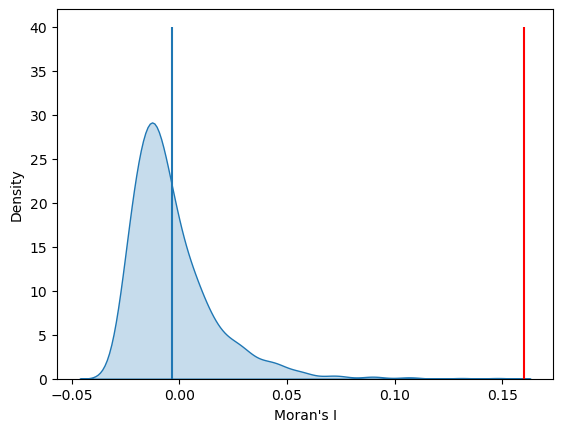

In [135]:
sns.kdeplot(mi.sim, shade=True)
plt.vlines(mi.I, 0, 40, color='r')
plt.vlines(mi.EI, 0, 40)
plt.xlabel("Moran's I")

In [136]:
# Check the statistical significance
mi.p_sim

0.001

This is just 0.1% (or you may get 0.002, 0.003..., slightly different everytime) and would be considered statistically significant. It means if we try to allocate the same values randomlly over space to get new map, then the Moran's $I$ statistic for new map could have 0.1% possibility to display a larger $I$ value than the one from our real data; while 99.9% of random mapping would receive a smaller $I$ value. As $I$ value could also be interpreted as the slope for Moran plot, the airbnb listing price in London is more concentrated than if it follows a CSR process, hence statistically significance, and has its spatial structure. 

Besides of calling `esda` in PySAL, we can also realize the Moran's I statistic by directly calling the specific function in `PySAL.explore.esda.Moran`. 

In [137]:
# Bandung
I_airbnb = ps.explore.esda.moran.Moran(airbnb_bdg['listings_c'], w_queen)  # Moran's I
I_airbnb.I, I_airbnb.p_sim  #value of statistic, inference on Moran's I

(0.15999456721761104, 0.001)

In [138]:
# Jakarta
I_airbnb2 = ps.explore.esda.Moran(airbnb_jkt['listings_c'].values, w_queen_jkt)  # Moran's I
I_airbnb2.I, I_airbnb2.p_sim  #value of statistic, inference on Moran's I

(0.07814253297801745, 0.005)

We can arrive at the conclusion now: the pattern for airbnb listing is not spatially random, but instead has signficant spatial association.
### <a id='Local spatial autocorrelation'>Local spatial autocorrelation<a/>
We implement Local Indicators of Spatial Association (LISAs) for Moran’s I and Getis and Ord’s G in PySal to detect hotspots.

We use Local Moran's I index to test the spatial autocorrelationality. It will measure the spatial autocorrelation in an attribute y measured over n spatial units. To calculate Moran’s I we first need to create and read in a GAL file for a weights matrix W. In order to get W, we need to work out what polygons neighbour each other (e.g. Queen Style Contiguity Neighbours, and Rook's Case Neighbours, etc.). 

Read more in R.Bivand (2017) "Finding Neighbours".

Instead of a single $I$ statistic, we have an *array* of local $I_i$ statistics, stored in the `.Is` attribute, and p-values from the simulation are in `p_sim`.


In [139]:
lisa = ps.explore.esda.Moran_Local(airbnb_bdg['listings_c'].values, w_queen, permutations=999)
lisa_jkt = ps.explore.esda.Moran_Local(airbnb_jkt['listings_c'].values, w_queen_jkt, permutations=999)
lisa.Is

array([ 4.25612159e-02,  4.25612159e-02,  4.36674632e-02,  4.36674632e-02,
        4.36674632e-02,  4.36674632e-02,  4.36674632e-02,  4.36674632e-02,
        4.36674632e-02,  4.36674632e-02,  4.36674632e-02,  4.36674632e-02,
        4.36674632e-02,  4.36674632e-02,  4.36674632e-02,  4.36674632e-02,
        4.36674632e-02,  4.36674632e-02,  4.36674632e-02,  4.36674632e-02,
        4.36674632e-02,  4.36674632e-02,  4.36674632e-02,  4.36674632e-02,
        4.36674632e-02,  4.36674632e-02,  3.84379306e-02,  3.84379306e-02,
        4.23600800e-02,  4.23600800e-02,  4.14549686e-02,  4.14549686e-02,
        4.04716377e-02,  4.04716377e-02,  4.07912203e-02,  4.07912203e-02,
        4.25612159e-02,  4.25612159e-02,  2.75326157e-02,  3.97453137e-02,
        3.95585447e-02,  3.95585447e-02,  2.65305398e-02,  3.75040855e-02,
        3.75040855e-02,  3.75040855e-02,  4.36674632e-02,  4.36674632e-02,
        4.36674632e-02,  4.36674632e-02,  4.36674632e-02,  4.36674632e-02,
        4.36674632e-02,  

In [140]:
lisa.q   # quantile classification
lisa_jkt.q   # quantile classification

array([4, 2, 3, 3, 3, 3, 3, 3, 3, 3, 1, 2, 3, 3, 3, 3, 3, 3, 1, 2, 3, 3,
       3, 3, 4, 3, 1, 2, 3, 3, 1, 2, 1, 2, 3, 3, 3, 3, 3, 3, 1, 2, 3, 3,
       3, 3, 4, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 1, 2, 3, 3, 3, 3,
       3, 3, 3, 3, 1, 2, 1, 2, 3, 3, 1, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       1, 2, 1, 2, 3, 3, 3, 3, 1, 2, 4, 2, 3, 3, 3, 3, 1, 2, 1, 2, 1, 2,
       3, 3, 2, 2, 3, 3, 4, 2, 1, 2, 1, 2, 3, 3, 3, 3, 3, 3, 3, 3, 4, 2,
       3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 4, 2, 3, 3, 2, 2, 2, 2, 1, 2, 2, 2,
       2, 2, 4, 3, 3, 3, 3, 3, 3, 3, 1, 2, 4, 3, 2, 2, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 1, 2, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 1, 2, 3, 3, 3, 3, 1, 2, 1, 2, 1, 2, 3, 3,
       1, 2, 3, 3, 3, 3, 3, 3, 3, 3, 1, 2, 4, 2, 1, 2, 4, 3, 3, 3, 1, 2,
       3, 3, 1, 2, 3, 3, 1, 2, 3, 3, 3, 3, 4, 2, 3, 3, 3, 3, 4, 2, 2, 2,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 4, 3, 3, 3, 3, 3, 1, 2, 2, 2,
       3, 3, 1, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,

In [141]:
lisa.p_sim
lisa_jkt.p_sim

array([0.41 , 0.234, 0.105, 0.136, 0.256, 0.256, 0.175, 0.175, 0.026,
       0.067, 0.192, 0.085, 0.117, 0.117, 0.037, 0.088, 0.091, 0.091,
       0.003, 0.001, 0.483, 0.483, 0.424, 0.461, 0.432, 0.49 , 0.302,
       0.253, 0.028, 0.028, 0.248, 0.184, 0.332, 0.242, 0.494, 0.494,
       0.292, 0.3  , 0.072, 0.072, 0.233, 0.079, 0.16 , 0.182, 0.089,
       0.097, 0.362, 0.377, 0.03 , 0.037, 0.485, 0.485, 0.38 , 0.325,
       0.057, 0.113, 0.07 , 0.07 , 0.467, 0.434, 0.299, 0.256, 0.064,
       0.064, 0.124, 0.169, 0.136, 0.171, 0.016, 0.016, 0.259, 0.179,
       0.161, 0.142, 0.04 , 0.04 , 0.206, 0.126, 0.5  , 0.5  , 0.039,
       0.039, 0.022, 0.022, 0.313, 0.313, 0.268, 0.268, 0.083, 0.058,
       0.191, 0.081, 0.494, 0.494, 0.139, 0.139, 0.127, 0.11 , 0.369,
       0.313, 0.128, 0.182, 0.383, 0.383, 0.233, 0.153, 0.253, 0.232,
       0.127, 0.105, 0.491, 0.491, 0.348, 0.335, 0.293, 0.328, 0.417,
       0.277, 0.073, 0.066, 0.038, 0.011, 0.01 , 0.01 , 0.012, 0.02 ,
       0.082, 0.116,

In [142]:
(lisa.p_sim < 0.05).sum()
(lisa_jkt.p_sim < 0.05).sum()

100

A Moran scatterplot with statistically significant LISA values highlighted. We want to plot the statistically-significant LISA values in a different color than the others. To do this, first find all of the statistically significant LISAs. Since the $p$-values are in the same order as the $I_i$ statistics, we can do this in the following way.

In [143]:
# Bandung
airbnb_bdg['lag_airbnb'] = lps.weights.lag_spatial(w_queen, airbnb_bdg['listings_c'])
sigs = airbnb_bdg['listings_c'][lisa.p_sim <= .05]
W_sigs = airbnb_bdg['lag_airbnb'][lisa.p_sim <= .05]
insigs = airbnb_bdg['listings_c'][lisa.p_sim > .05]
W_insigs = airbnb_bdg['lag_airbnb'][lisa.p_sim > .05]

In [144]:
b,a = np.polyfit(airbnb_bdg['listings_c'], airbnb_bdg['lag_airbnb'], 1)
moran=ps.explore.esda.Moran(airbnb_bdg['listings_c'].values, w_queen)

Text(0.5, 0, 'Airbnb Listings')

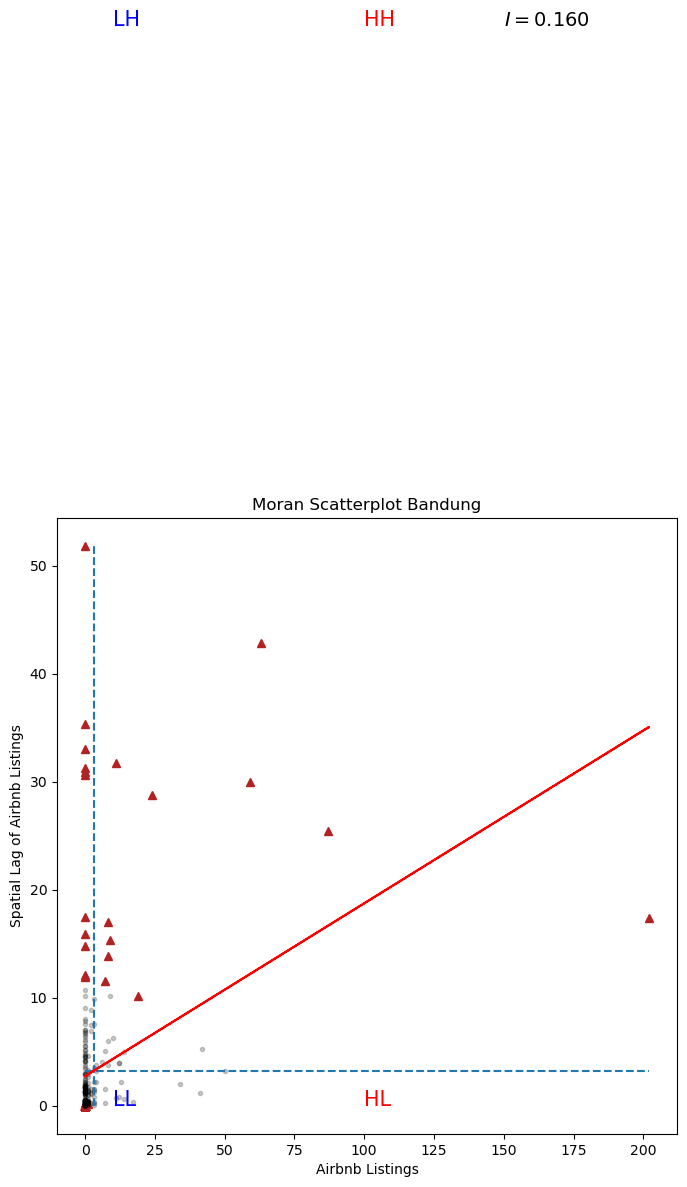

In [145]:
fig, ax=plt.subplots(1, figsize=(8,8))
plt.plot(sigs, W_sigs, '^', color='firebrick')
plt.plot(insigs, W_insigs, '.k', alpha=.2)
 # dashed vert at mean of the last year's PCI
plt.vlines(airbnb_bdg['listings_c'].mean(), airbnb_bdg['lag_airbnb'].min(), airbnb_bdg['lag_airbnb'].max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(airbnb_bdg['lag_airbnb'].mean(), airbnb_bdg['listings_c'].min(), airbnb_bdg['listings_c'].max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(airbnb_bdg['listings_c'], a + b*airbnb_bdg['listings_c'], 'r')
plt.text(s='$I = %.3f$' % moran.I, x=150, y=100, fontsize=14)
plt.text(100, 100, "HH", fontsize=15, color='r')
plt.text(100, 0, "HL", fontsize=15, color='r')
plt.text(10, 100, "LH", fontsize=15, color='b')
plt.text(10, 0, "LL", fontsize=15, color='b')
plt.title('Moran Scatterplot Bandung')
plt.ylabel('Spatial Lag of Airbnb Listings')
plt.xlabel('Airbnb Listings')

Text(0.5, 0, 'Airbnb Listings')

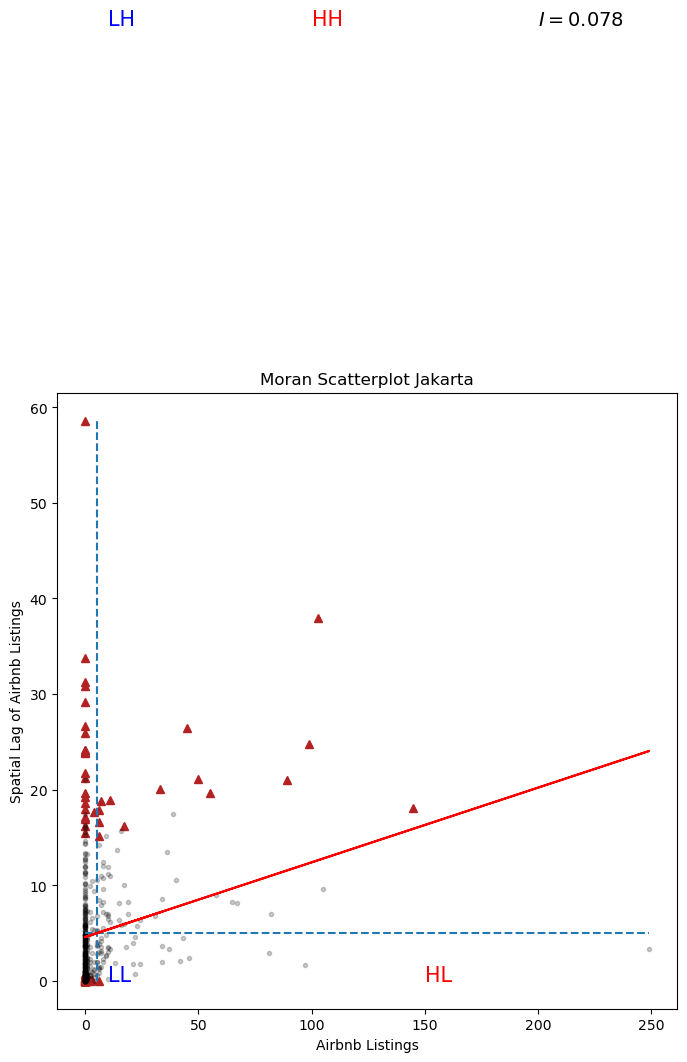

In [146]:
#Jakarta
airbnb_jkt['lag_airbnb'] = lps.weights.lag_spatial(w_queen_jkt, airbnb_jkt['listings_c'])
sigs = airbnb_jkt['listings_c'][lisa_jkt.p_sim <= .05]
W_sigs = airbnb_jkt['lag_airbnb'][lisa_jkt.p_sim <= .05]
insigs = airbnb_jkt['listings_c'][lisa_jkt.p_sim > .05]
W_insigs = airbnb_jkt['lag_airbnb'][lisa_jkt.p_sim > .05]

b,a = np.polyfit(airbnb_jkt['listings_c'], airbnb_jkt['lag_airbnb'], 1)
moran=ps.explore.esda.Moran(airbnb_jkt['listings_c'].values, w_queen_jkt)

fig, ax=plt.subplots(1, figsize=(8,8))
plt.plot(sigs, W_sigs, '^', color='firebrick')
plt.plot(insigs, W_insigs, '.k', alpha=.2)
 # dashed vert at mean of the last year's PCI
plt.vlines(airbnb_jkt['listings_c'].mean(), airbnb_jkt['lag_airbnb'].min(), airbnb_jkt['lag_airbnb'].max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(airbnb_jkt['lag_airbnb'].mean(), airbnb_jkt['listings_c'].min(), airbnb_jkt['listings_c'].max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(airbnb_jkt['listings_c'], a + b*airbnb_jkt['listings_c'], 'r')
plt.text(s='$I = %.3f$' % moran.I, x=200, y=100, fontsize=14)
plt.text(100, 100, "HH", fontsize=15, color='r')
plt.text(150, 0, "HL", fontsize=15, color='r')
plt.text(10, 100, "LH", fontsize=15, color='b')
plt.text(10, 0, "LL", fontsize=15, color='b')
plt.title('Moran Scatterplot Jakarta')
plt.ylabel('Spatial Lag of Airbnb Listings')
plt.xlabel('Airbnb Listings')

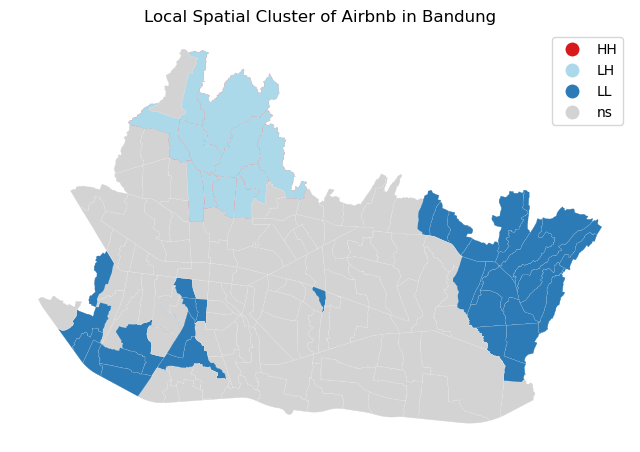

In [147]:
fig, ax=plt.subplots(1, figsize=(8,6))
fig = lisa_cluster(lisa, airbnb_bdg, ax=ax)
plt.title("Local Spatial Cluster of Airbnb in Bandung")
plt.show()

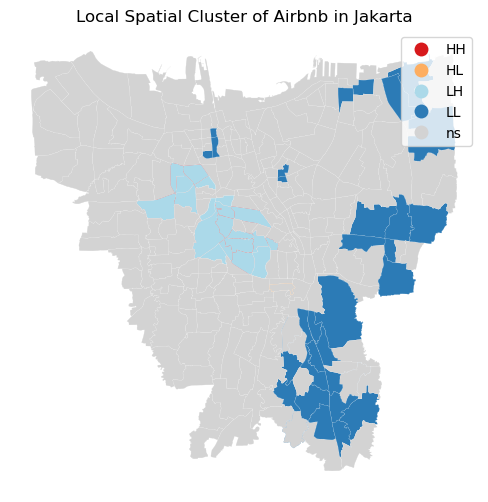

In [148]:
fig, ax=plt.subplots(1, figsize=(8,6))
fig = lisa_cluster(lisa_jkt, airbnb_jkt, ax=ax)
plt.title("Local Spatial Cluster of Airbnb in Jakarta")
plt.show()

In [149]:
#So far, only high value surrounded by high values has been highlighted. 
#However, we can distinguish the specific type of local spatial association reflected in the four quadrants of the Moran Scatterplot as:
sig = lisa.p_sim < 0.05
hotspot = sig * lisa.q==1
coldspot = sig * lisa.q==3
doughnut = sig * lisa.q==2
diamond = sig * lisa.q==4

### Spatial Lag Model
In a similar way to how we have included the spatial lag, we could try the spatial lag model estimation with maximum likelihood. `Spatial lag` is the product of the spatial weights matrix and a given variable and that, if 𝑊 is row-standardized, the result amounts to the average value of the variable in the neighborhood of each observation. Recall your memory on Spatial Lag model from lecture, and use `ML_Lag` class in `pysal.model.spreg` to estimate this model.

In [161]:
# Bandung
# read the .dbf file from your shapefile data
f = lps.io.open('AirbnbPOI_bdg.dbf','r')

In [162]:
# Read in the listing_price (dependent variable) into an array y
y = np.array(f.by_col['Revenue_US'])
y.shape = (len(y),1)
# value for independent variables into a one dimmensional array X. 
# You can feel free to change the independant variables
X= []
X.append(f.by_col['Hotel_Dens'])# Mall
X.append(f.by_col['Mall_Densi'])
X.append(f.by_col['Attracti_1'])
X.append(f.by_col['Restaura_1'])
X.append(f.by_col['Parks_Dens'])
X = np.array(X).T

In [163]:
mi = ps.explore.esda.moran.Moran(airbnb_bdg['Revenue_US'], w_queen, two_tailed=False)
print("The Statistic Moran's I is: "+str("%.4f"%mi.I),
      "\nThe Expected Value for Statistic I is: "+str("%.4f"%mi.EI),
      "\nThe Significance Test Value is: "+str("%.4f"%mi.p_norm))

The Statistic Moran's I is: 0.2054 
The Expected Value for Statistic I is: -0.0033 
The Significance Test Value is: 0.0000


In [174]:
from spreg import OLS

reg = OLS(y,X,name_y='Revenue', name_x=['Hotels', 'Malls','Attractions','Restaurants','Parks'], name_ds='Airbnb Bandung')
print(reg.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :Airbnb Bandung
Weights matrix      :        None
Dependent Variable  :     Revenue                Number of Observations:         302
Mean dependent var  :   9019.5000                Number of Variables   :           6
S.D. dependent var  :  44574.0532                Degrees of Freedom    :         296
R-squared           :      0.1490
Adjusted R-squared  :      0.1346
Sum squared residual:508932944883.487                F-statistic           :     10.3652
Sigma-square        :1719368057.039                Prob(F-statistic)     :   3.559e-09
S.E. of regression  :   41465.263                Log likelihood        :   -3636.538
Sigma-square ML     :1685208426.767                Akaike info criterion :    7285.076
S.E of regression ML:  41051.2902                Schwarz criterion     :    7307.338

-------------------------------------------------------------------

In [153]:
spat_lag = ML_Lag(y,X,W_queen, name_y='Revenue', 
                  name_x=['Hotels', 'Malls','Attractions','Restaurants','Parks'],
                  name_w='w_queen', name_ds='Airbnb Bandung')
print(spat_lag.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :Airbnb Bandung
Weights matrix      :     w_queen
Dependent Variable  :     Revenue                Number of Observations:         302
Mean dependent var  :   9019.5000                Number of Variables   :           7
S.D. dependent var  :  44574.0532                Degrees of Freedom    :         295
Pseudo R-squared    :      0.2097
Spatial Pseudo R-squared:  0.1905
Sigma-square ML     :1567681878.569                Log likelihood        :   -3628.232
S.E of regression   :   39593.963                Akaike info criterion :    7270.465
                                                 Schwarz criterion     :    7296.438

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
-------------------------

In [154]:
SEM = ML_Error(y,X,W_queen, name_y='Revenue', 
                  name_x=['Hotels', 'Malls','Attractions','Restaurants','Parks'],
                  name_w='w_queen', name_ds='Airbnb Bandung')
print(SEM.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL ERROR (METHOD = FULL)
-------------------------------------------------------------------
Data set            :Airbnb Bandung
Weights matrix      :     w_queen
Dependent Variable  :     Revenue                Number of Observations:         302
Mean dependent var  :   9019.5000                Number of Variables   :           6
S.D. dependent var  :  44574.0532                Degrees of Freedom    :         296
Pseudo R-squared    :      0.1426
Sigma-square ML     :1604544140.211                Log likelihood        :   -3631.850
S.E of regression   :   40056.761                Akaike info criterion :    7275.700
                                                 Schwarz criterion     :    7297.963

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
-------------------------------------------------------

In [155]:
print("autoregressive coefficient is ""{0:.6f}".format(spat_lag.rho)) #estimate of spatial autoregressive coefficient
print(np.around(spat_lag.betas, decimals=4)) #array of estimated coefficients
print("Mean of dependent variable is ""{0:.6f}".format(spat_lag.mean_y)) #Mean of dependent variable
print("Standard deviation of dependent variable is ""{0:.6f}".format(spat_lag.std_y))#Standard deviation of dependent variable
print(np.around(np.diag(spat_lag.vm1), decimals=4))#Variance covariance matrix (k+2 x k+2) includes sigma2
print(np.around(np.diag(spat_lag.vm), decimals=4)) #Variance covariance matrix (k+1 x k+1) - includes lambda
print("Sigma squared used in computations is ""{0:.6f}".format(spat_lag.sig2))#Sigma squared used in computations
print("{0:.6f}".format(spat_lag.logll)) #maximized log-likelihood (including constant terms)

autoregressive coefficient is 0.408065
[[ 1.5921256e+03]
 [ 9.1693086e+03]
 [-4.8050755e+03]
 [ 4.6241980e+03]
 [ 9.0035227e+03]
 [-7.1868337e+03]
 [ 4.0810000e-01]]
Mean of dependent variable is 9019.500000
Standard deviation of dependent variable is 44574.053239
[7.19184632e+06 1.96346337e+07 7.22362861e+06 1.08246359e+07
 5.69873239e+06 1.46480071e+07 8.70000000e-03 1.64666374e+16]
[7.19184632e+06 1.96346337e+07 7.22362861e+06 1.08246359e+07
 5.69873239e+06 1.46480071e+07 8.70000000e-03]
Sigma squared used in computations is 1567681878.568917
-3628.232457


In [175]:
# Jakarta
# read the .dbf file from your shapefile data
data = lps.io.open('AirbnbPOI_jkt.dbf','r')
# Read in the listing_price (dependent variable) into an array y
y = np.array(data.by_col['Revenue_US'])
y.shape = (len(y),1)
# value for independent variables into a one dimmensional array X. 
# You can feel free to change the independant variables
X= []
X.append(data.by_col['Hotel_Dens'])# Mall
X.append(data.by_col['Mall_Densi'])
X.append(data.by_col['Attracti_1'])
X.append(data.by_col['Restaura_1'])
X.append(data.by_col['Parks_Dens'])
X = np.array(X).T
X

array([[0.82956259, 1.67597765, 1.00806452, 0.15313936, 1.1299435 ],
       [0.82956259, 1.67597765, 1.00806452, 0.15313936, 1.1299435 ],
       [0.        , 0.        , 0.        , 0.11485452, 0.05649718],
       ...,
       [0.15082956, 0.        , 0.        , 0.        , 0.50847458],
       [0.07541478, 0.        , 0.        , 0.        , 0.        ],
       [0.07541478, 0.        , 0.        , 0.        , 0.        ]])

In [157]:
mi = ps.explore.esda.moran.Moran(airbnb_jkt['Revenue_US'], w_queen_jkt, two_tailed=False)
print("The Statistic Moran's I is: "+str("%.4f"%mi.I),
      "\nThe Expected Value for Statistic I is: "+str("%.4f"%mi.EI),
      "\nThe Significance Test Value is: "+str("%.4f"%mi.p_norm))

The Statistic Moran's I is: 0.0649 
The Expected Value for Statistic I is: -0.0019 
The Significance Test Value is: 0.0006


In [176]:
reg = OLS(y,X,name_y='Revenue', name_x=['Hotels', 'Malls','Attractions','Restaurants','Parks'], name_ds='Airbnb Jakarta')
print(reg.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :Airbnb Jakarta
Weights matrix      :        None
Dependent Variable  :     Revenue                Number of Observations:         524
Mean dependent var  :  13304.2977                Number of Variables   :           6
S.D. dependent var  :  56449.5623                Degrees of Freedom    :         518
R-squared           :      0.1133
Adjusted R-squared  :      0.1048
Sum squared residual:1477679196598.885                F-statistic           :     13.2429
Sigma-square        :2852662541.697                Prob(F-statistic)     :   3.712e-12
S.E. of regression  :   53410.322                Log likelihood        :   -6444.644
Sigma-square ML     :2819998466.792                Akaike info criterion :   12901.289
S.E of regression ML:  53103.6578                Schwarz criterion     :   12926.858

------------------------------------------------------------------

In [158]:
spat_lag = ML_Lag(y,X,w_queen_jkt, name_y='Revenue', 
                  name_x=['Hotels', 'Malls','Attractions','Restaurants','Parks'],
                  name_w='w_queen', name_ds='Airbnb Jakarta')
print(spat_lag.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :Airbnb Jakarta
Weights matrix      :     w_queen
Dependent Variable  :     Revenue                Number of Observations:         524
Mean dependent var  :  13304.2977                Number of Variables   :           7
S.D. dependent var  :  56449.5623                Degrees of Freedom    :         517
Pseudo R-squared    :      0.1152
Spatial Pseudo R-squared:  0.1179
Sigma-square ML     :2814165963.639                Log likelihood        :   -6444.288
S.E of regression   :   53048.713                Akaike info criterion :   12902.576
                                                 Schwarz criterion     :   12932.407

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
-------------------------

In [159]:
SEM = ML_Error(y,X,w_queen_jkt, name_y='Revenue', 
                  name_x=['Hotels', 'Malls','Attractions','Restaurants','Parks'],
                  name_w='w_queen', name_ds='Airbnb Jakarta')
print(SEM.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL ERROR (METHOD = FULL)
-------------------------------------------------------------------
Data set            :Airbnb Jakarta
Weights matrix      :     w_queen
Dependent Variable  :     Revenue                Number of Observations:         524
Mean dependent var  :  13304.2977                Number of Variables   :           6
S.D. dependent var  :  56449.5623                Degrees of Freedom    :         518
Pseudo R-squared    :      0.1133
Sigma-square ML     :2812070303.156                Log likelihood        :   -6444.222
S.E of regression   :   53028.957                Akaike info criterion :   12900.444
                                                 Schwarz criterion     :   12926.013

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
-------------------------------------------------------